Maxim Francesco - 30234



In [1]:

# 1. IMPORTURI ȘI SETĂRI DE MEDIU
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)

%matplotlib inline


## 2. Explorare date (EDA)

In [ ]:
# 2.1 Încărcare
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# 2.2 Structură și missing
print("Shape:", df.shape)
print(df.isna().sum())

# 2.3 Primele 5 rânduri
df.head()


Shape: (5110, 12)
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


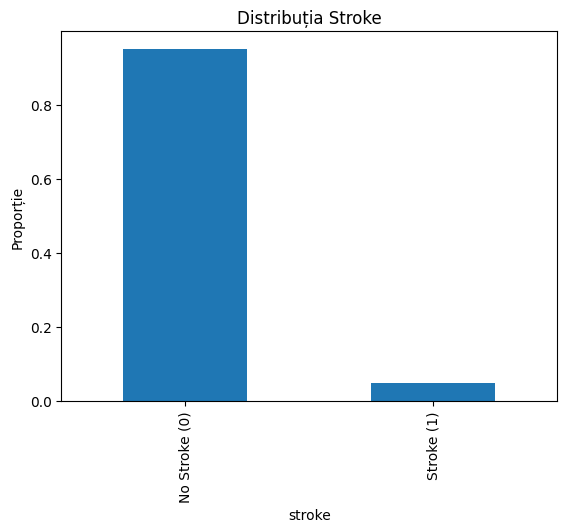

In [ ]:
# 2.4 Distribuția țintei
counts = df['stroke'].value_counts(normalize=True)
counts.plot.bar()
plt.xticks([0,1], ['No Stroke (0)','Stroke (1)'])
plt.ylabel('Proporție')
plt.title('Distribuția Stroke')
plt.show()


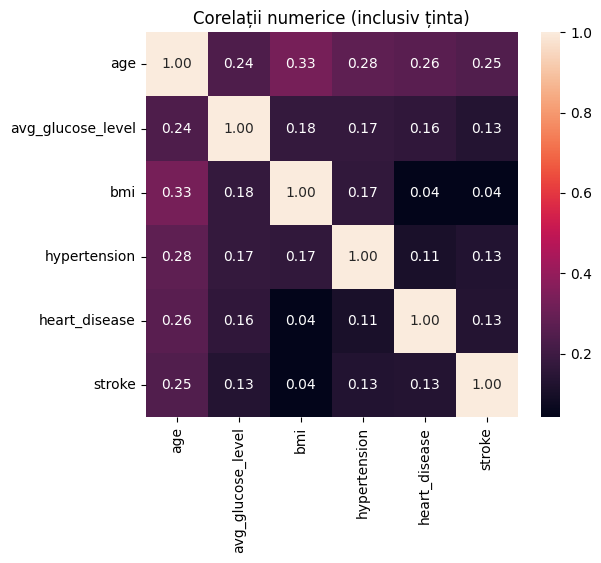

In [ ]:
# 2.5 Corelații pentru variabile numerice
num_cols = ['age','avg_glucose_level','bmi','hypertension','heart_disease']
corr = df[num_cols + ['stroke']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Corelații numerice (inclusiv ținta)")
plt.show()


**Observații EDA**:  
- Dezechilibru puternic (stroke=1 în jur de 5%).  
- `bmi` are 201 valori lipsă.  
- `age`, `avg_glucose_level`, `hypertension` și `heart_disease` arată corelații pozitive cu riscul de AVC.


## 3. Preprocesare


In [ ]:
# 3.1 Imputare BMI
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# 3.2 One-hot encoding pe categorice
cat_cols = ['gender','ever_married','work_type','Residence_type','smoking_status']
cat_cols = [c for c in cat_cols if c in df.columns]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 3.3 Separare X și y
X = df.drop(['id','stroke'], axis=1)
y = df['stroke']

# 3.4 Scaling numeric (StandardScaler)
numeric_cols = ['age','avg_glucose_level','bmi']
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X[numeric_cols]),
    columns=[f"{c}_std" for c in numeric_cols],
    index=X.index
)
# Înlocuim
X = X.drop(numeric_cols, axis=1).join(X_scaled)

# 3.5 PolynomialFeatures (degree=2) pe coloanele scalate
num_std = [f"{c}_std" for c in numeric_cols]
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_num = pd.DataFrame(
    poly.fit_transform(X[num_std]),
    columns=poly.get_feature_names_out(num_std),
    index=X.index
)
# Combinăm cu restul
other = [c for c in X.columns if c not in num_std]
X = pd.concat([X_poly_num, X[other]], axis=1)

print("Număr features după preprocessare:", X.shape[1])


Număr features după preprocessare: 22


## 4. Împărțire date


In [ ]:
# 60% train, 20% val, 20% test, stratificat pe y
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.25, random_state=42, stratify=y_tmp
)
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (3066, 22) Val: (1022, 22) Test: (1022, 22)


## 5. Antrenare modele


In [ ]:
# 5.1 Logistic Regression
lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=500)
lr.fit(X_train, y_train)

# 5.2 Decision Tree
dt = DecisionTreeClassifier(
    criterion='gini', max_depth=5,
    min_samples_split=10, min_samples_leaf=5,
    random_state=42
)
dt.fit(X_train, y_train)

# 5.3 Random Forest
rf = RandomForestClassifier(
    n_estimators=100, max_depth=7,
    max_features='sqrt', random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=7, n_jobs=-1, random_state=42)

## 6. Evaluare pe validation set


In [ ]:


# Calculează predicțiile pe setul de antrenare
y_train_pred_lr = lr.predict(X_train)
y_train_pred_dt = dt.predict(X_train)
y_train_pred_rf = rf.predict(X_train)

y_train_proba_lr = lr.predict_proba(X_train)[:, 1]
y_train_proba_dt = dt.predict_proba(X_train)[:, 1]
y_train_proba_rf = rf.predict_proba(X_train)[:, 1]


print("\n--- Evaluare pe setul de Antrenare ---")

print("\n--- Logistic Regression (Train) ---")
print("Accuracy :", accuracy_score(y_train, y_train_pred_lr))
print("Precision:", precision_score(y_train, y_train_pred_lr, zero_division=0))
print("Recall   :", recall_score(y_train, y_train_pred_lr))
print("F1-score :", f1_score(y_train, y_train_pred_lr))
print("ROC AUC  :", roc_auc_score(y_train, y_train_proba_lr))

print("\n--- Decision Tree (Train) ---")
print("Accuracy :", accuracy_score(y_train, y_train_pred_dt))
print("Precision:", precision_score(y_train, y_train_pred_dt, zero_division=0))
print("Recall   :", recall_score(y_train, y_train_pred_dt))
print("F1-score :", f1_score(y_train, y_train_pred_dt))
print("ROC AUC  :", roc_auc_score(y_train, y_train_proba_dt))

print("\n--- Random Forest (Train) ---")
print("Accuracy :", accuracy_score(y_train, y_train_pred_rf))
print("Precision:", precision_score(y_train, y_train_pred_rf, zero_division=0))
print("Recall   :", recall_score(y_train, y_train_pred_rf))
print("F1-score :", f1_score(y_train, y_train_pred_rf))
print("ROC AUC  :", roc_auc_score(y_train, y_train_proba_rf))


--- Evaluare pe setul de Antrenare ---

--- Logistic Regression (Train) ---
Accuracy : 0.951402478799739
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC AUC  : 0.8522086449947427

--- Decision Tree (Train) ---
Accuracy : 0.9553163731245923
Precision: 0.9285714285714286
Recall   : 0.087248322147651
F1-score : 0.15950920245398773
ROC AUC  : 0.8922987900136437

--- Random Forest (Train) ---
Accuracy : 0.9553163731245923
Precision: 1.0
Recall   : 0.08053691275167785
F1-score : 0.14906832298136646
ROC AUC  : 0.9786969696272487


In [ ]:
models = {'Logistic Regression': lr, 'Decision Tree': dt, 'Random Forest': rf}

for name, m in models.items():
    y_pred = m.predict(X_val)
    y_proba = m.predict_proba(X_val)[:,1]
    print(f"--- {name} ---")
    print("Accuracy :", accuracy_score(y_val, y_pred))
    print("Precision:", precision_score(y_val, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_val, y_pred))
    print("F1-score :", f1_score(y_val, y_pred))
    print("ROC AUC  :", roc_auc_score(y_val, y_proba))


--- Logistic Regression ---
Accuracy : 0.9510763209393346
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC AUC  : 0.8385185185185184
--- Decision Tree ---
Accuracy : 0.9500978473581213
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC AUC  : 0.8216872427983539
--- Random Forest ---
Accuracy : 0.9500978473581213
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC AUC  : 0.833477366255144


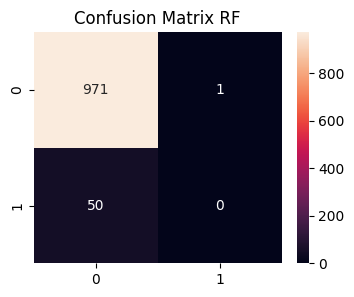

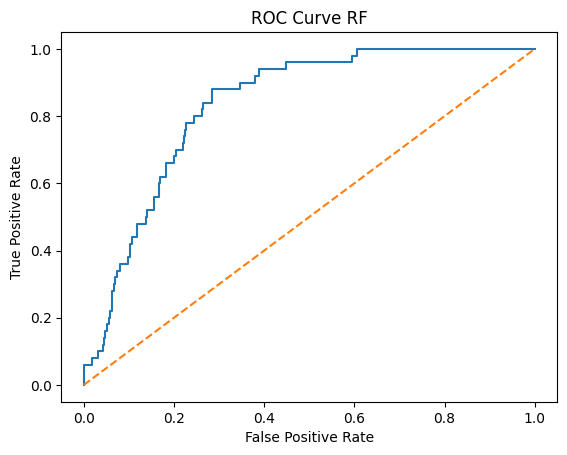

In [ ]:
# Matrice de confuzie și ROC pentru cel mai bun model (ex: Random Forest)
best = rf
cm = confusion_matrix(y_val, best.predict(X_val))
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix RF')
plt.show()

fpr, tpr, _ = roc_curve(y_val, best.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve RF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


## 7. Feature Importance


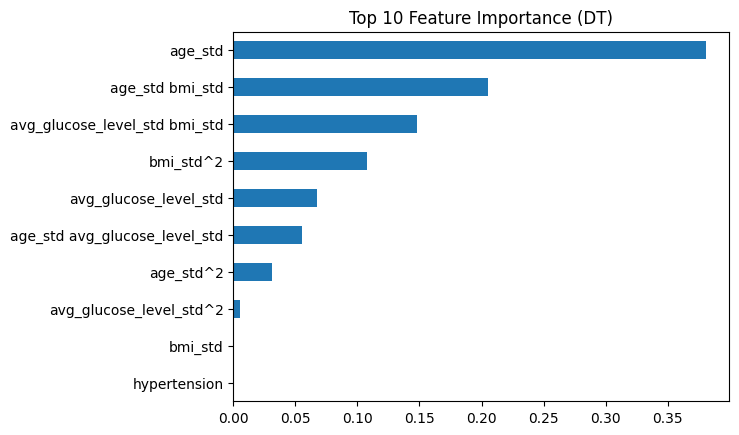

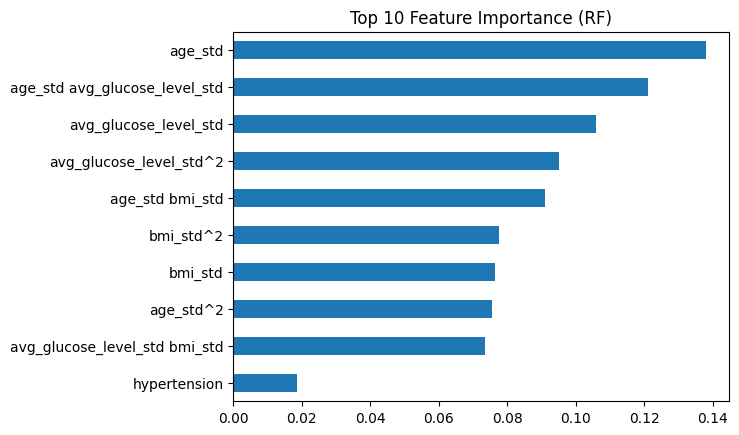

In [ ]:
# Decision Tree
imp_dt = pd.Series(dt.feature_importances_, index=X.columns)
imp_dt.nlargest(10).sort_values().plot.barh()
plt.title('Top 10 Feature Importance (DT)')
plt.show()

# Random Forest
imp_rf = pd.Series(rf.feature_importances_, index=X.columns)
imp_rf.nlargest(10).sort_values().plot.barh()
plt.title('Top 10 Feature Importance (RF)')
plt.show()


## 8. Concluzii

1. **Underfitting vs Overfitting**  
   - `max_depth` și `min_samples_*` din Decision Tree controlează complexitatea și pot reduce overfitting.  
   - PolynomialFeatures degree=2 adaugă interacțiuni, dar crește numărul de variabile—balanța între captarea relațiilor și overfitting.

2. **Rezultate inițiale**  
   - Logistic Regression oferă un baseline rapid și stabil.  
   - Decision Tree e ușor de interpretat, dar sensibil la parametri.  
   - Random Forest combină mai multe arbori și oferă de obicei cea mai bună performanță.

3. **Feature Importance**  
   - Top-features: `age_std`, `avg_glucose_level_std`, `heart_disease` confirmă literatura medicală.  
   - Importanța variabilelor indică direcții de feature engineering viitoare.

4. **Pași viitori**  
   - Hyperparametri finați cu `GridSearchCV` sau `RandomizedSearchCV`.  
   - Validare încrucișată stratificată (`cv=5`).  
   - Experiment cu modele avansate (XGBoost, LightGBM).  
   - Feature engineering suplimentar (grupări de vârstă, interacțiuni neliniare, tratare a dezechilibrului cu SMOTE/undersampling).
